# Vector Rally

In [7]:
import tensorflow as tf
import tensorflow.contrib.layers as layer
import numpy as np
from matplotlib.pyplot import *
%matplotlib inline

/Users/matjoerg/my_python/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Track environment
Manages states, actions and rewards.

In [253]:
class TrackEnvironment():
    def __init__(self, track_width, track_length, vector_length):
        # Track width
        self.track_width = track_width
        self.track_length = track_length
        self.vector_length = vector_length
        
    def Track(self, x):
        # Track function
        return (np.cos(2*np.pi*x) - 1.5)/3.5, (-1*(np.cos(2*np.pi*x) - 1.5) + self.track_width)/3.5
    
    def OnTrack(self, p):
        # Check if vector is on the track
        x = p[0]
        y = p[1]
        
        return self.Track(x)[0] < y < self.Track(x)[1] and 0 < x < self.track_length
    
    def step(self, p, action):
        # Returns new state and reward given current state and action
        x = p[0]
        y = p[1]
        
        new_theta = action - p[2]
        new_x = x + np.cos(new_theta)*self.vector_length
        new_y = y + np.sin(new_theta)*self.vector_length
        
        p_new = np.array([new_x, new_y, new_theta])
        
        dead = (not self.OnTrack(p_new))
        win = (new_x > self.track_length)
        
        if win:
            r = 50
        elif dead:
            r = -100
        else:
            r = -1
            
        return r, p_new, dead, win

#### Discount function

In [254]:
gamma = 0.99

def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, len(r))):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

## Agent

In [255]:
class PGnetwork():
    def __init__(self,n_samples,n_hidden=20):
        self.stateaction = tf.placeholder(shape=[None,3,1], dtype=tf.float32)
        
        conv_layer1 = layer.conv2d(inputs=self.stateaction,
                                   kernel_size=1,
                                   num_outputs=50,
                                   activation_fn=tf.nn.relu)
        
        conv_layer2 = layer.conv2d(inputs=conv_layer1,
                                   kernel_size=2,
                                   num_outputs=5,
                                   activation_fn=tf.nn.relu)
        
        layer1 = layer.fully_connected(inputs=tf.reshape(conv_layer2,shape=np.array([-1,3*5])),
                                       num_outputs=n_hidden)
        layer2 = layer.fully_connected(inputs=layer1,
                                       num_outputs=n_hidden)
        layer3 = layer.fully_connected(inputs=layer2,
                                       num_outputs=n_hidden)
        
        self.pi = layer.fully_connected(inputs=layer3,
                                        num_outputs=n_samples,
                                        activation_fn=tf.nn.softmax)
        
        self.rewards = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        
        self.indexes = tf.range(0, tf.shape(self.pi)[0]) * tf.shape(self.pi)[1] + self.actions
        self.chosen_pi = tf.gather(tf.reshape(self.pi, [-1]), self.indexes)

        self.loss = -tf.reduce_mean(tf.log(self.chosen_pi)*self.rewards)
        
        trainer = tf.train.AdamOptimizer(learning_rate=0.001)
        self.train = trainer.minimize(self.loss)

## Training the Agent

In [259]:
# learning parameters
e = 0.1
num_episodes = 10000
n_samples = 10

Agent = PGnetwork(n_samples=n_samples)
Env = TrackEnvironment(track_width=1, track_length=1, vector_length=0.1)

# starting position
p0 = np.array([0.,0.,0.])
actions = np.linspace(0,2*np.pi,n_samples)

# save positions and rewards
rList = []
xList = []
yList = []
wins = 0
init = tf.global_variables_initializer()

# batches
p_batch = []
reward_batch = []
action_batch = []

with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        if (i+1)%200 == 0:
            print("Episode {}, wins: {}".format(i+1,wins))

        if i%5 == 0 and i != 0:
            p_batch = np.array(p_batch)
            reward_batch = np.array(reward_batch)

            action_batch = np.array(action_batch)
            
            p_batch = p_batch.reshape(p_batch.shape[0],p_batch.shape[1],1)
            #reward_batch = reward_batch.reshape(reward_batch.shape[0],1)
            #action_batch = action_batch.reshape(action_batch.shape[0],1)    
            
            train_steps = 1
            for j in range(train_steps):
                _,cost = sess.run([Agent.train,Agent.loss],feed_dict={Agent.stateaction:p_batch,
                                                                      Agent.rewards:reward_batch,
                                                                      Agent.actions:action_batch})
                print(cost)
                
            p_batch = []
            reward_batch = []
            action_batch = []
            
        p = p0
        rAll = []
        xAll = [p[0]]
        yAll = [p[1]]
        dead = False
        step = 0
        while step < 99:
            step += 1
            # choose action based on n_sample random samples
            pi = sess.run([Agent.pi],feed_dict={Agent.stateaction:p.reshape(1,3,1)})
            arga = np.random.choice(range(len(actions)),p=pi[0][0])
            #if np.random.rand(1) < e:
            #    arga = np.random.randint(0,n_samples)
            a = actions[arga]
                
            # new position and reward
            r, p_new, dead, win = Env.step(p,a)
            wins += win
            
            p_batch.append(p)
            action_batch.append(arga)
            
            p = p_new
            rAll.append(r)
            xAll.append(p[0])
            yAll.append(p[1])
            discount_r = [0]
            if dead is True:
                discount_r = discount_rewards(rAll)
                for ri in discount_r:
                    reward_batch.append(ri)
                break
                
        rList.append(np.sum(discount_r))
        xList.append(xAll)
        yList.append(yAll)

/Users/matjoerg/my_python/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


-230.425
-229.452
-230.611
-230.724
-230.831
-232.182
-230.195
-230.227
-229.76
-230.767
-5.245
-229.634
-225.001
-225.406
-233.14
-230.296
-232.415
-3.2982
-224.219
-231.496
-228.235
-227.728
-230.993
-230.496
-231.274
-229.107
-231.997
-135.511
-230.784
-226.526
-231.608
-231.005
-61.6337
-230.909
-230.596
-227.936
-228.586
-232.774


InvalidArgumentError: Incompatible shapes: [112] vs. [13]
	 [[Node: mul_99 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Log_49, _arg_Placeholder_148_0_1)]]

Caused by op 'mul_99', defined at:
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/matjoerg/my_python/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/matjoerg/my_python/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/matjoerg/my_python/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/Users/matjoerg/my_python/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/matjoerg/my_python/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/matjoerg/my_python/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/matjoerg/my_python/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/matjoerg/my_python/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/matjoerg/my_python/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/matjoerg/my_python/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/matjoerg/my_python/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/matjoerg/my_python/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/matjoerg/my_python/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "/Users/matjoerg/my_python/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/matjoerg/my_python/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/matjoerg/my_python/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/matjoerg/my_python/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/matjoerg/my_python/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-259-15a9ff72ca7e>", line 6, in <module>
    Agent = PGnetwork(n_samples=n_samples)
  File "<ipython-input-255-7755db948481>", line 32, in __init__
    self.loss = -tf.reduce_mean(tf.log(self.chosen_pi)*self.rewards)
  File "/Users/matjoerg/my_python/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 894, in binary_op_wrapper
    return func(x, y, name=name)
  File "/Users/matjoerg/my_python/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 1117, in _mul_dispatch
    return gen_math_ops._mul(x, y, name=name)
  File "/Users/matjoerg/my_python/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 2726, in _mul
    "Mul", x=x, y=y, name=name)
  File "/Users/matjoerg/my_python/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/matjoerg/my_python/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/Users/matjoerg/my_python/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Incompatible shapes: [112] vs. [13]
	 [[Node: mul_99 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Log_49, _arg_Placeholder_148_0_1)]]


In [264]:
pi

[array([[ 0.07453606,  0.0712676 ,  0.14344233,  0.07135388,  0.19989559,
          0.08973555,  0.06693254,  0.12880161,  0.06848656,  0.08554839]], dtype=float32)]

## Plotting final result

ValueError: x and y must have same first dimension, but have shapes (10000,) and (195,)

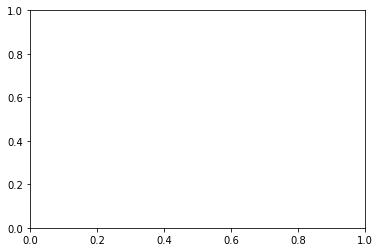

In [263]:
figure()
plot(range(num_episodes),rList)

show()

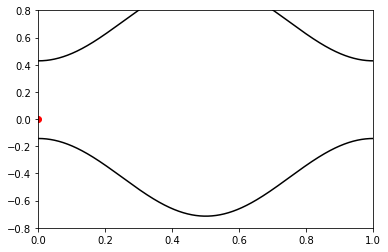

In [260]:
Env = TrackEnvironment(track_width=1, track_length=1, vector_length=0.1)

figure()
xs = np.linspace(0,1,1000)

plot(xs,Env.Track(xs)[0],'k-')
plot(xs,Env.Track(xs)[1],'k-')

plot(xList[-2],yList[-2],'r-o')

xlim([0,1])
ylim([-0.8,0.8])
#axis('equal')
show()

In [261]:
rList[-1]

0

In [262]:
discount_r

[0]